# Algorithm 3 from Neal (2000)

Implementation of the algorithm 3 form Neal (2000). With a Normal-Inverse-Wishart prior. The computation of the integral is obtained from Murphy (2007) (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_t
from scipy.stats import entropy
import random
import copy
from tqdm import tqdm

Imports from our own code files :

In [3]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('../../main_code')))
from main_code.neal_algorithm_3 import algorithm_3
from main_code.partitions_analysis import *
from main_code.data_generation import generate_gaussian_mixture

## 1. Functions for our assumptions

Define function to compute likelihood of some observation belonging to a given cluster given our assumptions

In [4]:
# These functions change based on assumption on the prior parameters of the model
def compute_mu_0(Y):
    return np.mean(Y, axis=0)   # default to mean of data, reasonable assumption

def compute_nu_0(D):
    return D    # default to D, potentially change this

def compute_inv_scale_mat_0(D):
    return np.eye(D)    # default to identity, potentially change this

def compute_lamb_0(Y):
    return 1    # default to 1, potentially change this


def integral_func_1(Y, cluster, i):
    """
    Compute the first integral using student_t distribution based on Murphy (2007) parameters
    """
    D = len(Y[0])
    mu_0 = compute_mu_0(Y)
    lamb_0 = compute_lamb_0(Y)
    nu_0 = compute_nu_0(D)
    inv_scale_mat_0 = compute_inv_scale_mat_0(D)
    n = len(cluster)    # number of element currently in cluster (used n to be consistent with Murphy (2007) notation)
    
    cluster_Y = Y[np.isin(np.arange(len(Y)),cluster)]
    cluster_mean = np.mean(cluster_Y, axis=0)

    # based on Murphy (2007). These should not be changed
    mu_n = (lamb_0 * mu_0 + n * cluster_mean) / (lamb_0 + n)
    lamb_n = lamb_0 + n
    nu_n = nu_0 + n
    
     # compute scatter matrix
    S = np.zeros((D,D))
    for j in range(n):
        temp = Y[j] - cluster_mean
        S += np.outer(temp, temp)
    temp = cluster_mean - mu_0
    inv_scale_mat_n = inv_scale_mat_0 + S + ((lamb_0 * n) / (lamb_0 + n)) * np.outer(temp, temp)

    # Computes integral using pdf of student t
    student_df = nu_n - D + 1
    integral = multivariate_t.pdf(Y[i],
                                  mu_n,
                                  inv_scale_mat_n * ((lamb_n+1) / (lamb_n * student_df)),
                                  student_df)
    return integral

def integral_func_2(Y, i):
    """
    Computes the second integral using student_t distribution based on Murphy (2007) parameters.
    """
    D = len(Y[0])
    mu_0 = compute_mu_0(Y)
    lamb_0 = compute_lamb_0(Y)
    nu_0 = compute_nu_0(D)
    inv_scale_mat_0 = compute_inv_scale_mat_0(D)
    student_df = nu_0 - D + 1
    # Computes integral using pdf of student t
    integral = multivariate_t.pdf(Y[i],
                                  mu_0,
                                  inv_scale_mat_0 * ((lamb_0 + 1) / (lamb_0 * student_df)),
                                  student_df)
    return integral

## 2. Test with synthetic data

Generate and visualize synthethic data

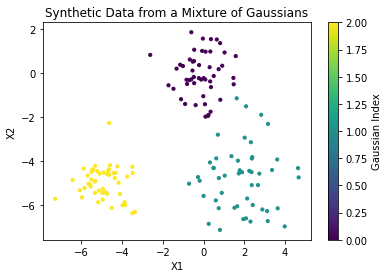

In [5]:
# Sample syntethic
np.random.seed(42)  # for reproducibility
random.seed(42)

means = [[0, 0], [2, -5], [-5, -5]]
covariances = [np.eye(2), 2 * np.eye(2), 0.5 * np.eye(2)]
n_samples = [50, 50, 50]

data, labels = generate_gaussian_mixture(means, covariances, n_samples)

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Synthetic Data from a Mixture of Gaussians")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Gaussian Index")
plt.show()


Apply algorithm 3 on synthetic data and visualize result

In [6]:
# these can be modified
n_steps = 5000
burn_in = 500
alpha = 1
history = algorithm_3(n_steps,
                      data,
                      integral_func_1,
                      integral_func_2,
                      alpha=alpha)

Markov Chain Progress: 100%|██████████| 5000/5000 [24:45<00:00,  3.37step/s]


Compute the similarity matix as a summary for the MCMC

In [7]:
M = sampled_sim_matrix(history[burn_in:], len(data))

Compute metrics to vizualize the evolution of the MCMC

In [8]:
entropies = list(map(compute_entropy, history))
temp = lambda x: binder_loss_list_format(x, M)
binder_losses = list(map(temp, history))

Vizualmize metrics

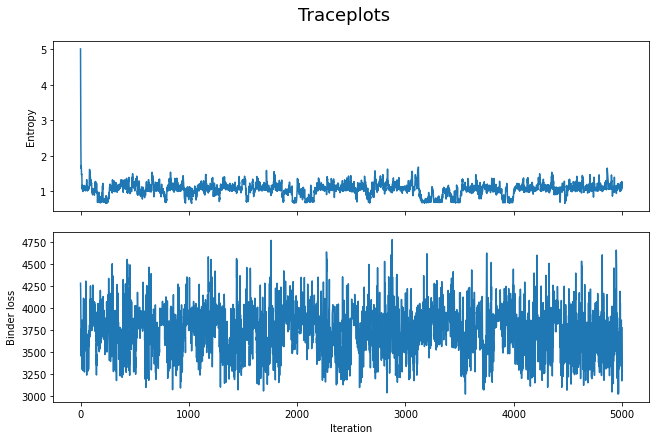

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, )
fig.set_size_inches(9,6)
fig.suptitle('Traceplots', fontsize=18)
fig.tight_layout()
ax[0].plot(entropies)
ax[0].set_ylabel("Entropy")
ax[1].plot(binder_losses)
ax[1].set_ylabel("Binder loss")
ax[1].set_xlabel("Iteration")
plt.show()

## 3. Point estimate

Compute a point estimate as the final result of the MCMC.

/Users/eliott/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


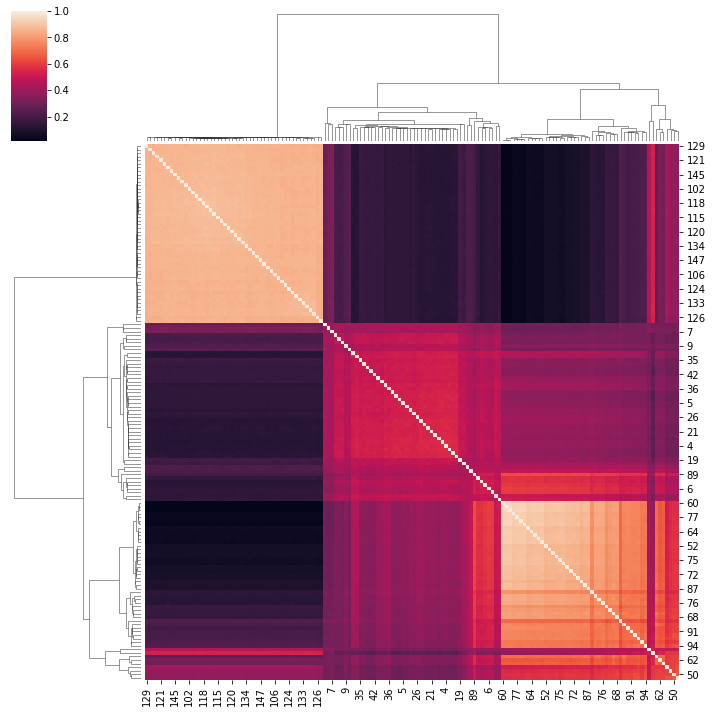

In [ ]:
sns.clustermap(M)


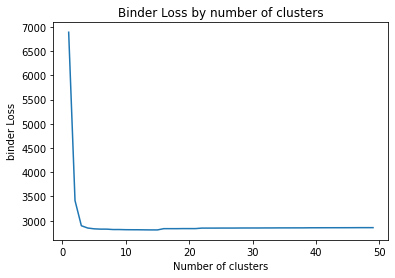

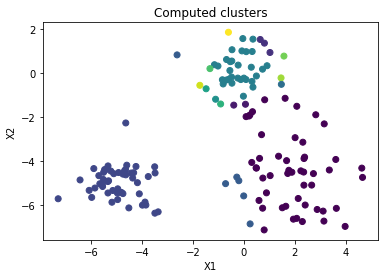

Number of clusters: 15


In [17]:
loss = lambda x: binder_loss_label_format(x, M)
best_clustering, best_n_clusters, scores = clusters_from_matrix(M, loss)

plt.title("Binder Loss by number of clusters")
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel("Number of clusters")
plt.ylabel("binder Loss")
plt.show()

plt.title("Computed clusters")
plt.scatter(data[:, 0], data[:, 1], c=best_clustering)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

print(f"Number of clusters: {best_n_clusters}")
